The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1
!pip install -U mxnet-cu101==1.7.0


# Redes com Concatenações Paralelas (GoogLeNet)
:label:`sec_googlenet`

Em 2014, *GoogLeNet*
venceu o ImageNet Challenge, propondo uma estrutura
que combinou as forças de NiN e paradigmas de blocos repetidos :cite:`Szegedy.Liu.Jia.ea.2015`.
Um dos focos do artigo foi abordar a questão
dos quais tamanhos de núcleos de convolução são os melhores.
Afinal, as redes populares anteriores empregavam escolhas
tão pequenas quanto $1 \times 1$ e tão grande quanto $11 \times 11$.
Uma ideia neste artigo foi que às vezes
pode ser vantajoso empregar uma combinação de grãos de vários tamanhos.
Nesta seção, apresentaremos GoogLeNet,
apresentando uma versão ligeiramente simplificada do modelo original:
nós
omitir alguns recursos ad-hoc que foram adicionados para estabilizar o treinamento
mas são desnecessários agora com melhores algoritmos de treinamento disponíveis.


## Inception Blocks

O bloco convolucional básico no GoogLeNet é chamado de *bloco Inception*,
provavelmente nomeado devido a uma citação do filme *Inception* ("Precisamos ir mais fundo"),
que lançou um meme viral.

![Estrutura do bloco Inception.](http://d2l.ai/_images/inception.svg)
:label:`fig_inception`

Conforme descrito em :numref:`fig_inception`,
o bloco de iniciação consiste em quatro caminhos paralelos.
Os primeiros três caminhos usam camadas convolucionais
com tamanhos de janela de $1\times 1$, $3\times 3$, e $5\times 5$
para extrair informações de diferentes tamanhos espaciais.
Os dois caminhos intermediários realizam uma convolução $1\times 1$ na entrada para
reduzir o número de canais, diminuindo a complexidade do modelo.
O quarto caminho usa uma camada de pooling máxima de $3\times 3$,
seguido por uma camada convolucional $1\times 1$
para alterar o número de canais.
Todos os quatro caminhos usam preenchimento apropriado para dar à entrada e saída a mesma altura e largura.
Finalmente, as saídas ao longo de cada caminho são concatenadas
ao longo da dimensão do canal e compreendem a saída do bloco.
Os hiperparâmetros comumente ajustados do bloco de início
são o número de canais de saída por camada.


In [1]:
from mxnet import np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

class Inception(nn.Block):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2D(c1, kernel_size=1, activation='relu')
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2D(c2[0], kernel_size=1, activation='relu')
        self.p2_2 = nn.Conv2D(c2[1], kernel_size=3, padding=1,
                              activation='relu')
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2D(c3[0], kernel_size=1, activation='relu')
        self.p3_2 = nn.Conv2D(c3[1], kernel_size=5, padding=2,
                              activation='relu')
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2D(pool_size=3, strides=1, padding=1)
        self.p4_2 = nn.Conv2D(c4, kernel_size=1, activation='relu')

    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension
        return np.concatenate((p1, p2, p3, p4), axis=1)

Para ter alguma intuição de por que essa rede funciona tão bem,
considere a combinação dos filtros.
Eles exploram a imagem em uma variedade de tamanhos de filtro.
Isso significa que os detalhes em diferentes extensões
pode ser reconhecido de forma eficiente por filtros de diferentes tamanhos.
Ao mesmo tempo, podemos alocar diferentes quantidades de parâmetros
para filtros diferentes.


## Modelo GoogLeNet 

Conforme mostrado em :numref:`fig_inception_full`, GoogLeNet usa uma pilha de um total de 9 blocos iniciais
e pooling médio global para gerar suas estimativas.
O agrupamento máximo entre os blocos de iniciação reduz a dimensionalidade.
O primeiro módulo é semelhante ao AlexNet e LeNet.
A pilha de blocos é herdada de VGG
e o pool de média global evita
uma pilha de camadas totalmente conectadas no final.

![A arquitetura GoogLeNet.](../img/inception-full.svg)
:label:`fig_inception_full`

Agora podemos implementar o GoogLeNet peça por peça.
O primeiro módulo usa uma camada convolucional $7\times 7$ de 64 canais.


In [2]:
b1 = nn.Sequential()
b1.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

O segundo módulo usa duas camadas convolucionais:
primeiro, uma camada convolucional $1\times 1$ de 64 canais,
em seguida, uma camada convolucional $3\times 3$ que triplica o número de canais. Isso corresponde ao segundo caminho no bloco *Inception*.


In [3]:
b2 = nn.Sequential()
b2.add(nn.Conv2D(64, kernel_size=1, activation='relu'),
       nn.Conv2D(192, kernel_size=3, padding=1, activation='relu'),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

O terceiro módulo conecta dois blocos de iniciação completos em série.
O número de canais de saída do primeiro bloco de iniciação é
$64+128+32+32=256$,
e a relação número de canal de saída
entre os quatro caminhos está $64:128:32:32=2:4:1:1$.
O segundo e o terceiro caminhos reduzem primeiro o número de canais de entrada
para $96/192=1/2$ e $16/192=1/12$, respectivamente,
e conecte a segunda camada convolucional.
O número de canais de saída do segundo bloco de iniciação
é aumentado para $128+192+96+64=480$, e a proporção do número de canal de saída
entre os quatro caminhos está  $128:192:96:64 = 4:6:3:2$.
O segundo e o terceiro caminhos reduzem primeiro o número de canais de entrada
a $128/256=1/2$ e $32/256=1/8$, respectivamente.


In [4]:
b3 = nn.Sequential()
b3.add(Inception(64, (96, 128), (16, 32), 32),
       Inception(128, (128, 192), (32, 96), 64),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

O quarto módulo é mais complicado.
Ele conecta cinco blocos de iniciação em série,
e eles têm $192+208+48+64=512$, $160+224+64+64=512$,
$128+256+64+64=512$, $112+288+64+64=528$,
e $256+320+128+128=832$ canais de saída, respectivamente.
O número de canais atribuídos a esses caminhos é semelhante
para aquele no terceiro módulo:
o segundo caminho com a camada convolucional $3\times 3$
produz o maior número de canais,
seguido pelo primeiro caminho com apenas a camada convolucional $1\times 1$,
o terceiro caminho com a camada convolucional $5\times 5$,
e o quarto caminho com a camada de pooling máxima $3\times 3$.
O segundo e terceiro caminhos irão primeiro reduzir
o número de canais de acordo com a proporção.
Essas proporções são ligeiramente diferentes em diferentes blocos *Inception*.


In [5]:
b4 = nn.Sequential()
b4.add(Inception(192, (96, 208), (16, 48), 64),
       Inception(160, (112, 224), (24, 64), 64),
       Inception(128, (128, 256), (24, 64), 64),
       Inception(112, (144, 288), (32, 64), 64),
       Inception(256, (160, 320), (32, 128), 128),
       nn.MaxPool2D(pool_size=3, strides=2, padding=1))

O quinto módulo tem dois blocos de iniciação com $256+320+128+128=832$
e$384+384+128+128=1024$ canais de saída.
O número de canais atribuídos a cada caminho
é o mesmo que no terceiro e quarto módulos,
mas difere em valores específicos.
Deve-se notar que o quinto bloco é seguido pela camada de saída.
Este bloco usa a camada de pooling média global
para alterar a altura e largura de cada canal para 1, assim como em NiN.
Por fim, transformamos a saída em uma matriz bidimensional
seguido por uma camada totalmente conectada
cujo número de saídas é o número de classes de rótulo.


In [6]:
b5 = nn.Sequential()
b5.add(Inception(256, (160, 320), (32, 128), 128),
       Inception(384, (192, 384), (48, 128), 128),
       nn.GlobalAvgPool2D())

net = nn.Sequential()
net.add(b1, b2, b3, b4, b5, nn.Dense(10))

O modelo GoogLeNet é computacionalmente complexo,
portanto, não é tão fácil modificar o número de canais como no VGG.
Para ter um tempo de treinamento razoável no Fashion-MNIST,
reduzimos a altura e largura de entrada de 224 para 96.
Isso simplifica o cálculo.
As mudanças na forma da saída
entre os vários módulos são demonstrados abaixo.


In [7]:
X = np.random.uniform(size=(1, 1, 96, 96))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

sequential0 output shape:	 (1, 64, 24, 24)
sequential1 output shape:	 (1, 192, 12, 12)
sequential2 output shape:	 (1, 480, 6, 6)
sequential3 output shape:	 (1, 832, 3, 3)
sequential4 output shape:	 (1, 1024, 1, 1)
dense0 output shape:	 (1, 10)


## Treinamento
 
Como antes, treinamos nosso modelo usando o conjunto de dados Fashion-MNIST.
  Nós o transformamos em resolução de $96 \times 96$ pixels
  antes de invocar o procedimento de treinamento.


loss 0.239, train acc 0.909, test acc 0.907
2236.9 examples/sec on gpu(0)


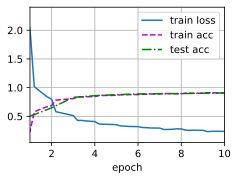

In [8]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Sumário

* O bloco de iniciação é equivalente a uma sub-rede com quatro caminhos. Ele extrai informações em paralelo por meio de camadas convolucionais de diferentes formatos de janela e camadas de agrupamento máximo. As convoluções $1 \times 1$ reduzem a dimensionalidade do canal em um nível por pixel. O pool máximo reduz a resolução.
* GoogLeNet conecta vários blocos de iniciação bem projetados com outras camadas em série. A proporção do número de canais atribuídos no bloco de iniciação é obtida por meio de um grande número de experimentos no conjunto de dados ImageNet.
* GoogLeNet, assim como suas versões subsequentes, foi um dos modelos mais eficientes no ImageNet, fornecendo precisão de teste semelhante com menor complexidade computacional.

## Exercícios

1. Existem várias iterações do GoogLeNet. Tente implementá-los e executá-los. Alguns deles incluem o seguinte:
     * Adicione uma camada de normalização em lote :cite:`Ioffe.Szegedy.2015`, conforme descrito
       mais tarde em :numref:`sec_batch_norm`.
     * Faça ajustes no bloco de iniciação
       :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
     * Use suavização de rótulo para regularização de modelo
       :cite:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
     * Incluir na conexão residual
       :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`, conforme descrito posteriormente em
       :numref:`sec_resnet`.
1. Qual é o tamanho mínimo de imagem para o GoogLeNet funcionar?
1. Compare os tamanhos dos parâmetros do modelo de AlexNet, VGG e NiN com GoogLeNet. Como as duas últimas arquiteturas de rede reduzem significativamente o tamanho do parâmetro do modelo?


[Discussão](https://discuss.d2l.ai/t/81)


<!--stackedit_data:
eyJoaXN0b3J5IjpbMTE5NDgzNjA2NywtMTYxNzcxNTc4M119
-->
